In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
import numpy as np
import cv2 as cv
from typing import Callable
# from pykdtree.kdtree import KDTree
from scipy.spatial import cKDTree

def show(im, title, show=True):
	plt.rcParams["figure.figsize"]=15,15
	plt.imshow(im, cmap='gray')
	plt.title(title)
	plt.xticks([])
	plt.yticks([])
	if show:
		plt.show()



In [70]:
image = cv.imread('./test.png')

table_width = 180
table_height = 230

height, width, _ = image.shape
aspect_ratio = width / height

# scale using width
new_width = int(table_width * (1 - table_width/width))
new_height = int(new_width/aspect_ratio)

print(f'Aspect ratio: {aspect_ratio}')
print(f'New dimensions: ({new_width}, {new_height})')

# scale image to size of table
# image = cv.resize(image, (new_width, new_height), interpolation=cv.INTER_NEAREST)

image = cv.resize(image, (new_width, new_height), interpolation=cv.INTER_AREA)

Aspect ratio: 1.0
New dimensions: (147, 147)


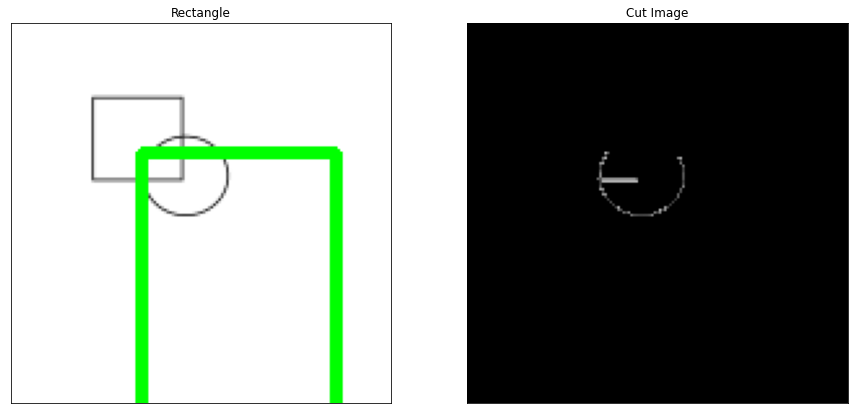

In [74]:
# TODO: improve with interactive mask refinement https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html
mask = np.zeros(image.shape[:2], np.uint8)

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

rect = np.array(([50, 50], [125, 200]))
im_with_rect = np.copy(image)
cv.rectangle(im_with_rect, rect[0], rect[1], (0, 255, 0), 3)

plt.subplot(121)
show(im_with_rect, 'Rectangle', False)

cv.grabCut(image, mask, rect.flatten(), bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
cut_im = image * mask2[:,:,np.newaxis]
plt.subplot(122)
show(cut_im, 'Cut Image')

In [71]:
@interact(min_threshold=100, max_threshold=200, aperture=(3,7,2))
def get_contours(min_threshold, max_threshold, aperture=3):
	# get edges using Canny edge detector
	global edges
	edges = cv.Canny(image, min_threshold, max_threshold, apertureSize=aperture)

	# display original image
	plt.subplot(121)
	# opencv stores image as bgr, need to convert back to display properly
	show(cv.cvtColor(image, cv.COLOR_BGR2RGB), 'Original Image', False)

	# display detected edges
	plt.subplot(122)
	show(edges, 'Edges')

interactive(children=(IntSlider(value=100, description='min_threshold', max=300, min=-100), IntSlider(value=20…

In [72]:
# TODO: RETR_EXTERNAL might be good
contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]

# hierarchy format: [next (same level), previous (same level), first_child, parent]
# roots have no parent (parent is -1). Get index for all roots
roots = [i for i, h in enumerate(hierarchy) if h[3] == -1]

w = widgets.IntSlider(value=-1, min=-1, max=len(contours))
@interact(cur_depth=w)
def draw_image(cur_depth):
	# display detected contours
	im_contours = image.copy()
	cmap = plt.cm.get_cmap('hsv', len(contours))

	def draw_hierarchy(root, depth, group_index):
		group_color = np.multiply(cmap(group_index), 255)
		# group_color = np.multiply(cmap(depth), 255)

		cur_hierarchy = hierarchy[root]

		contour = contours[root]
		if cur_depth == -1 or depth == cur_depth:
			cv.drawContours(im_contours, [contour], -1, group_color, 1)
			for c in contour:
				cv.circle(im_contours, c[0], 1, group_color, cv.FILLED)

		# draw children of this contour
		child_contour = cur_hierarchy[2]
		if (child_contour != -1):
			draw_hierarchy(child_contour, depth + 1, group_index)

		# draw other contours on current level
		cur_contour = cur_hierarchy[0]
		if (cur_contour != -1):
			draw_hierarchy(cur_contour, depth, group_index)


	for i, group in enumerate(roots):
		draw_hierarchy(group, 0, i)	
	# draw_hierarchy(roots[0], 0)	

	# for i, group in enumerate(contours):
	# 	group_color = np.multiply(cmap(i), 255)
	# 	cv.drawContours(im_contours, [group], -1, group_color, 1)
	# 	# cv.drawContours(im_contours, [group], -1, group_color, cv.FILLED)
	# 	for contour in group:
	# 		cv.circle(im_contours, contour[0], 2, group_color, cv.FILLED)

	show(im_contours, 'Contours')

interactive(children=(IntSlider(value=-1, description='cur_depth', max=12, min=-1), Output()), _dom_classes=('…

In [73]:
with open('out.g', 'w') as f:
	f.write('; BEGIN PRE\n')
	f.write('G28\n') # return to start
	f.write('G1 F1000\n') # set print speed
	f.write('M906 X200 Y200\n') # set stepper voltages
	f.write('M808 L0\n') # loop forever
	f.write('; END PRE\n')

	def merge_vertices(parent: np.ndarray, child: np.ndarray):
		closest_parent_vertex_index = 0
		closest_child_vertex_index = 0
		tree = cKDTree(parent)

		# use kd tree to find the closest vertex on parent/child
		dist, idx = tree.query(np.array(child))
		closest_child_vertex_index = np.argmin(dist)
		closest_parent_vertex_index = idx[closest_child_vertex_index]

		# merge vertices
		combined_vertices = []
		for i, vertex in enumerate(parent):
			combined_vertices.append(vertex)

			# connect vertex to the child contour
			if closest_parent_vertex_index == i:
				# make child array start at the index which connects to the parent 
				shifted_vertices = list(np.roll(child, -closest_child_vertex_index, 0))

				# wrap to first point
				# TODO: this might cause duplicate points since we wrap to the first point earlier in the function
				shifted_vertices.append(shifted_vertices[0])
				combined_vertices += shifted_vertices

				# readd original vertex to return to the parent object
				combined_vertices.append(vertex)
		return np.array(combined_vertices)

	def get_vertices(root_index: int):
		root_hierarchy = hierarchy[root_index]

		contour = contours[root_index]
		vertices = list(np.copy(contour))
		# wrap to return to first point
		vertices.append(vertices[0])
		vertices = np.array(vertices)
		vertices = np.reshape(vertices, (vertices.shape[0], vertices.shape[2]))

		# TODO: add min area to contours to filter out noise?

		# get child vertices
		child_index = root_hierarchy[2]
		children = [] 
		if (child_index != -1):
			child_vertices = get_vertices(child_index)
			children.append(child_vertices)
		children.sort(key=cv.contourArea)

		root_and_child_vertices = vertices.copy()
		for child in children:
			root_and_child_vertices = merge_vertices(root_and_child_vertices, child)

		# draw other contours on current level
		next_contour = root_hierarchy[0]
		combined_vertices = root_and_child_vertices.copy()
		if (next_contour != -1):
			vertices = get_vertices(next_contour)
			combined_vertices = merge_vertices(combined_vertices, vertices)

		return combined_vertices

	vertices = get_vertices(roots[0])
	for vertex in vertices:
		f.write(f'G01 X{vertex[0]} Y{vertex[1]}\n')